In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import skew
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import itertools
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
df= pd.read_csv("/content/drive/Shareddrives/STAT611 PROJECT TEAM/Data sets/Credit.csv")
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
df

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian,560
396,397,13.364,3838,296,5,65,17,Male,No,No,African American,480
397,398,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
398,399,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0


In [4]:
RESPONSE = "Balance"

df_pos = df[df[RESPONSE] > 0].copy()

print("Original data shape:", df.shape)
print("Positive-Balance subset shape:", df_pos.shape)

Original data shape: (400, 12)
Positive-Balance subset shape: (310, 12)


**Balance variable content lots of zero value, so for this project decided to work on positive subset of the project**

In [5]:
numeric_cols = []
categorical_cols = []

for c in df_pos.columns:
    if c == "ID":
        continue
    if pd.api.types.is_numeric_dtype(df_pos[c]):
        numeric_cols.append(c)
    else:
        categorical_cols.append(c)

In [6]:
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance']
Categorical columns: ['Gender', 'Student', 'Married', 'Ethnicity']


**Data Exploratory Analysis**


=== Histograms for numeric variables ===


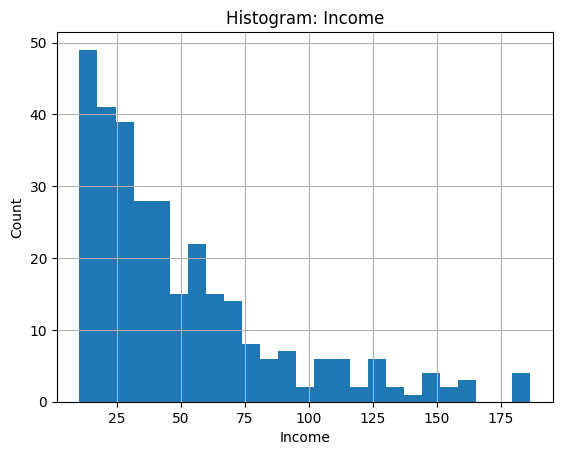

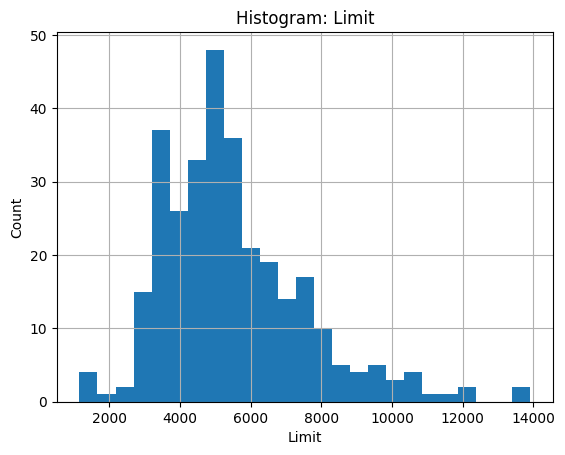

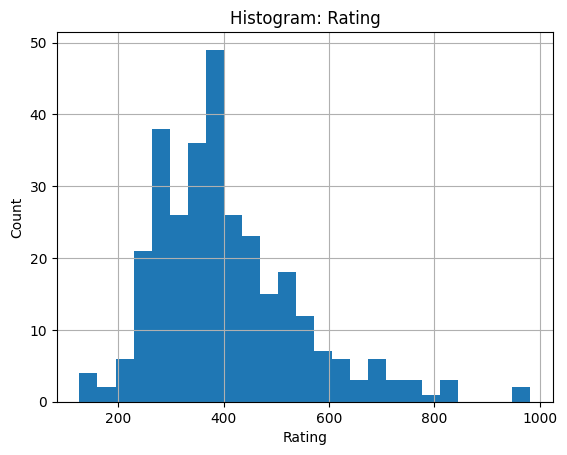

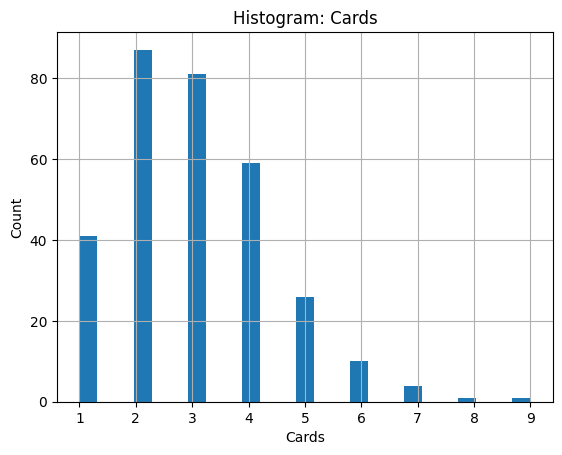

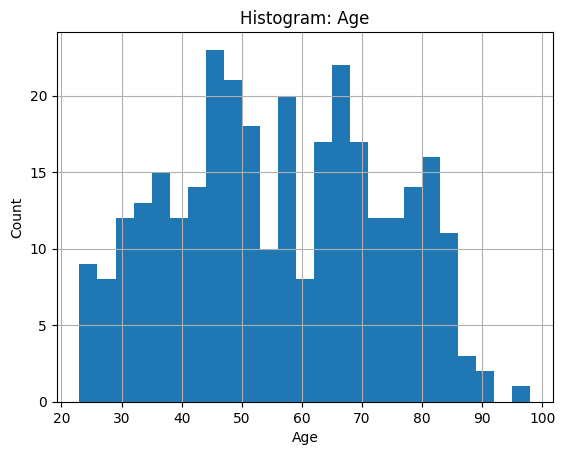

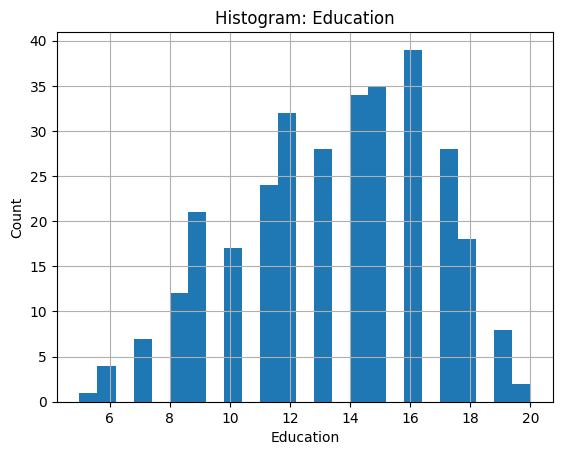

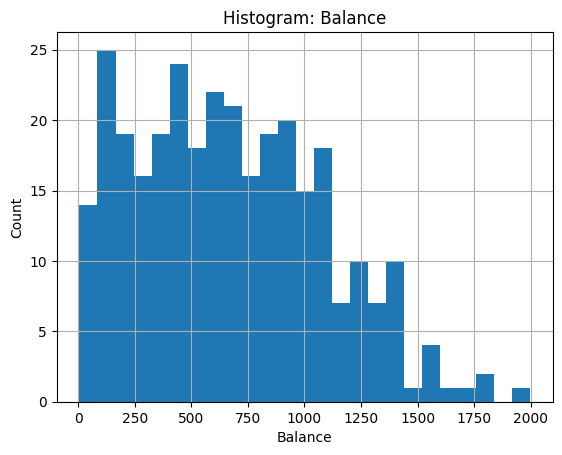

In [7]:
print("\n=== Histograms for numeric variables ===")
for c in numeric_cols:
    df_pos[c].hist(bins=25)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()


=== Scatterplot Matrix (All numeric variables) ===


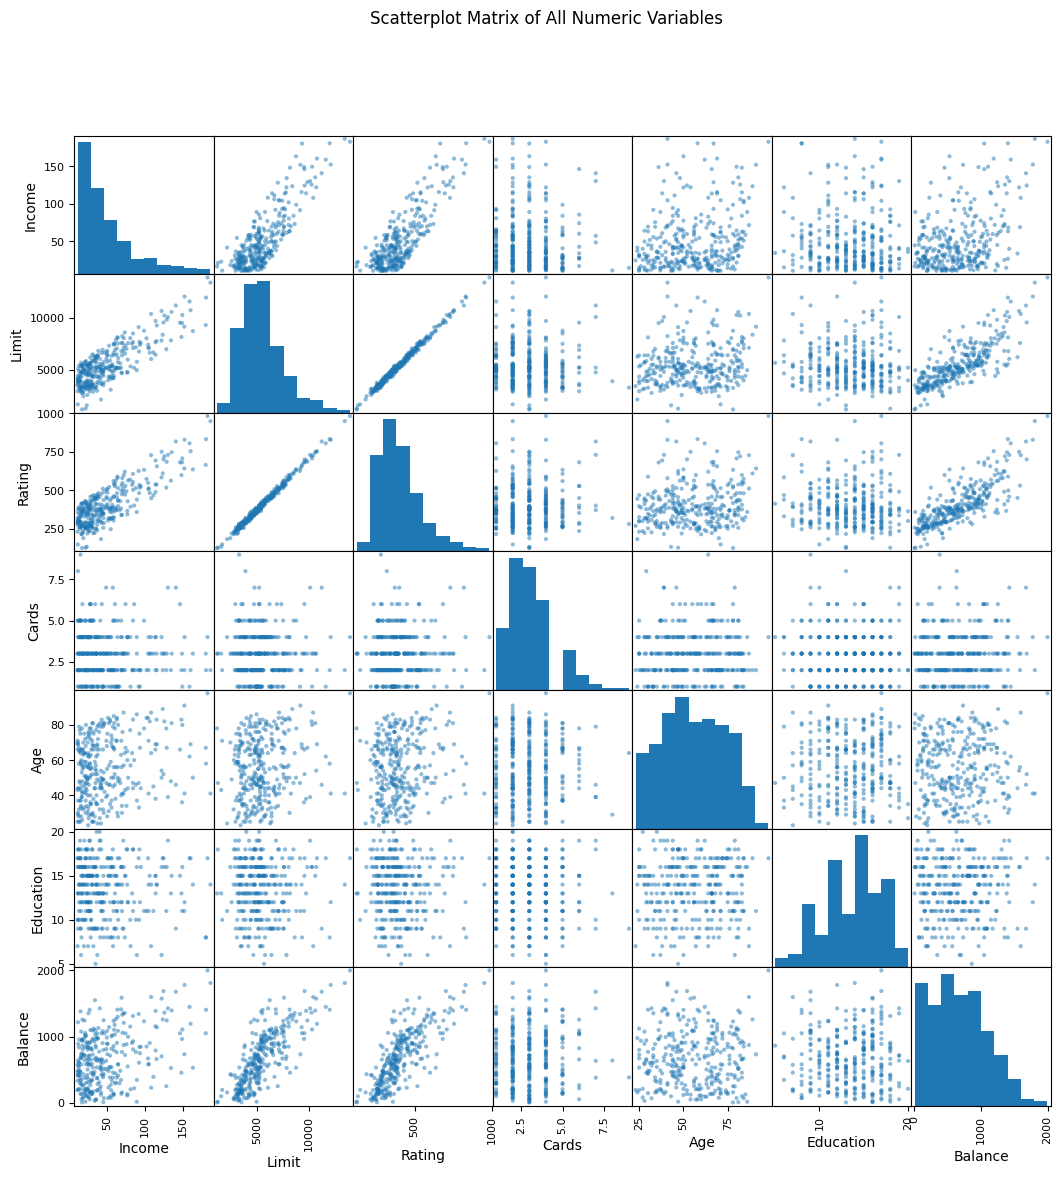

In [8]:
print("\n=== Scatterplot Matrix (All numeric variables) ===")
pd.plotting.scatter_matrix(df_pos[numeric_cols], figsize=(1.8*len(numeric_cols), 1.8*len(numeric_cols)), diagonal="hist")
plt.suptitle("Scatterplot Matrix of All Numeric Variables")
plt.show()


=== Correlation Matrix ===
           Income  Limit  Rating  Cards    Age  Education  Balance
Income      1.000  0.834   0.831 -0.040  0.227     -0.033    0.414
Limit       0.834  1.000   0.996 -0.023  0.164     -0.032    0.796
Rating      0.831  0.996   1.000  0.025  0.167     -0.040    0.798
Cards      -0.040 -0.023   0.025  1.000  0.021     -0.087    0.074
Age         0.227  0.164   0.167  0.021  1.000      0.024    0.008
Education  -0.033 -0.032  -0.040 -0.087  0.024      1.000    0.001
Balance     0.414  0.796   0.798  0.074  0.008      0.001    1.000


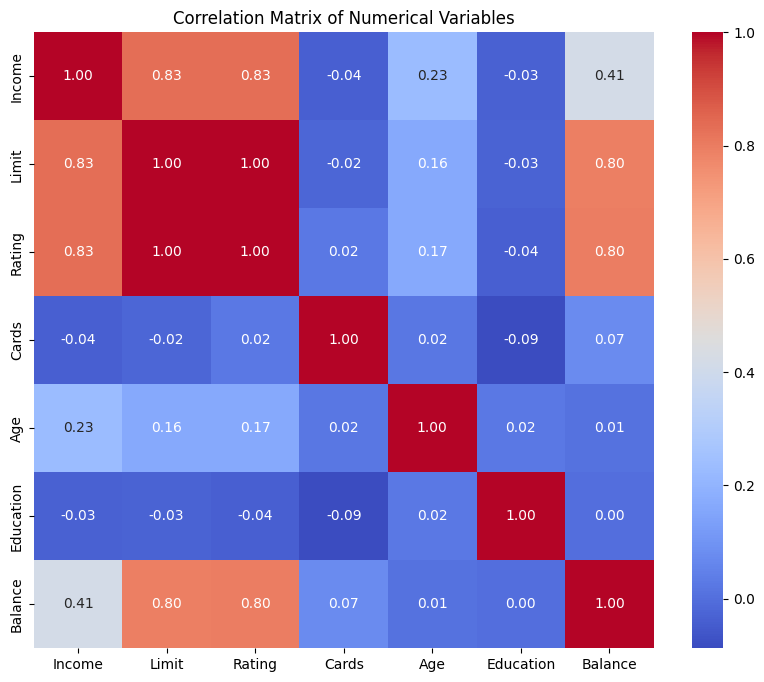

In [9]:
corr = df_pos[numeric_cols].corr()
print("\n=== Correlation Matrix ===")
print(corr.round(3))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In Model we will only include Limit, Income variables. As Rating is
highly correlated with limit, and there is no correlation between balance and
cards, age and educations.

In [10]:
numeric_cols = [c for c in numeric_cols if c not in ["Rating", "Cards", "Age", "Education"]]
numeric_cols

['Income', 'Limit', 'Balance']

In [11]:
# Basic descriptive stats
desc = df_pos.describe()

#outliers (values > Q3 + 1.5*IQR or < Q1 - 1.5*IQR) for each numeric column
outlier_summary = {}
for col in numeric_cols:
    Q1 = df_pos[col].quantile(0.25)
    Q3 = df_pos[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_pos[(df_pos[col] < lower) | (df_pos[col] > upper)][col]
    outlier_summary[col] = outliers.values.tolist()

print(desc)
print("\nOutlier summary (by column):")
for k,v in outlier_summary.items():
    print(f"{k}: {v[:40]}{'...' if len(v) > 40 else ''}")

               ID      Income         Limit      Rating       Cards  \
count  310.000000  310.000000    310.000000  310.000000  310.000000   
mean   202.441935   49.978810   5485.467742  405.051613    2.996774   
std    117.373087   37.881628   2052.451743  137.967389    1.426740   
min      1.000000   10.354000   1160.000000  126.000000    1.000000   
25%     98.250000   23.150250   3976.250000  304.000000    2.000000   
50%    209.500000   37.141000   5147.000000  380.000000    3.000000   
75%    306.500000   63.740250   6453.250000  469.000000    4.000000   
max    400.000000  186.634000  13913.000000  982.000000    9.000000   

              Age   Education      Balance  
count  310.000000  310.000000   310.000000  
mean    55.606452   13.425806   670.987097  
std     17.341794    3.208904   413.904019  
min     23.000000    5.000000     5.000000  
25%     42.000000   11.000000   338.000000  
50%     55.500000   14.000000   637.500000  
75%     69.000000   16.000000   960.750000  



=== Boxplots: Balance by categorical variables ===


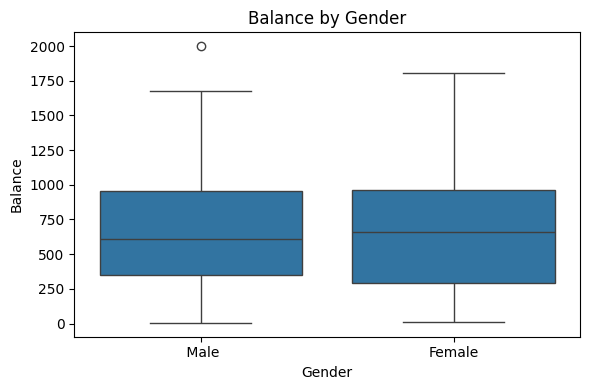

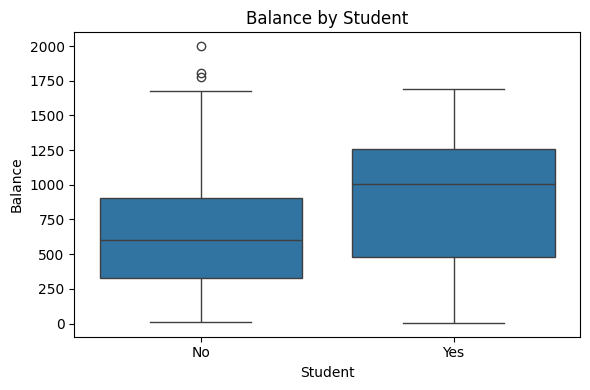

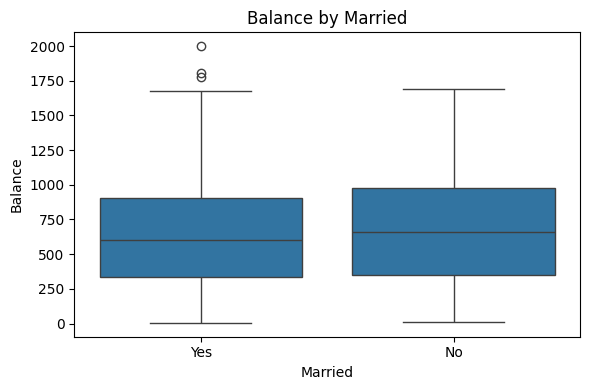

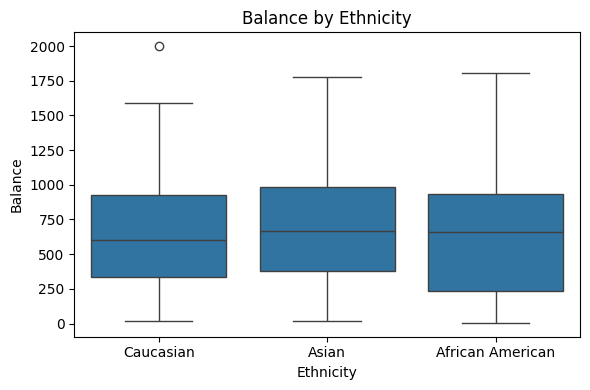

In [12]:
print("\n=== Boxplots: Balance by categorical variables ===")
for c in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_pos[c], y=df_pos['Balance'])
    plt.title(f'Balance by {c}')
    plt.tight_layout()
    plt.show()



Boxplots indicate that student status is associated with higher credit balances, while
gender, marital status, and ethnicity do not show strong effects on the distribution of balances. Some
group-level outliers are present, especially among students and Caucasians


=== Scatterplots of Balance vs numeric predictors by Gender ===


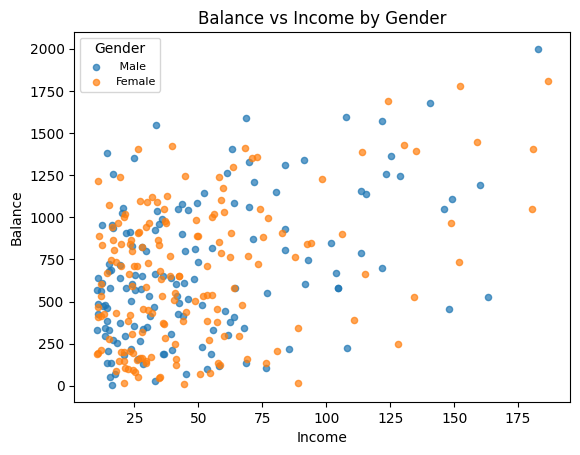

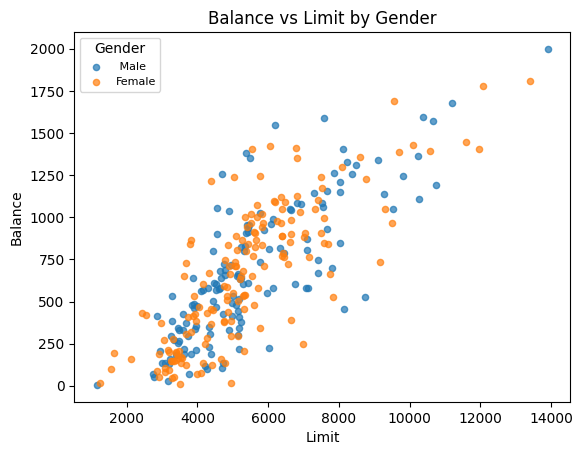


=== Scatterplots of Balance vs numeric predictors by Student ===


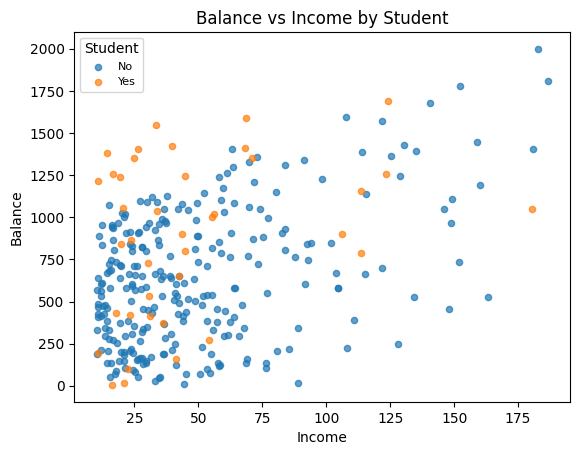

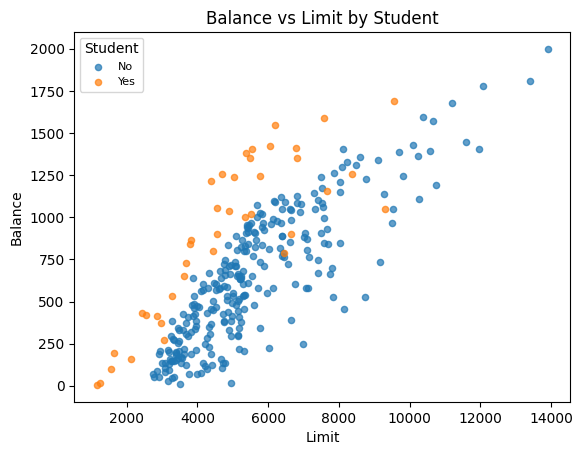


=== Scatterplots of Balance vs numeric predictors by Married ===


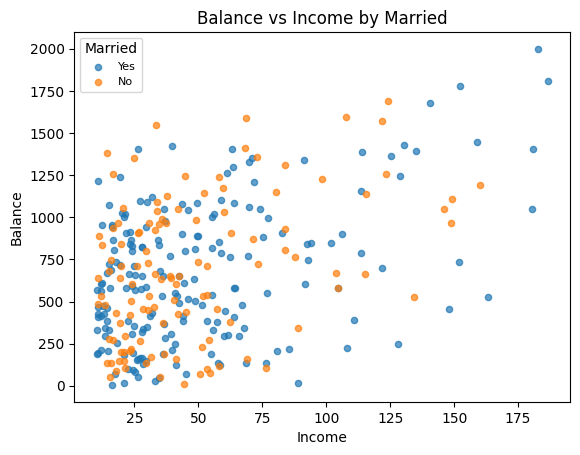

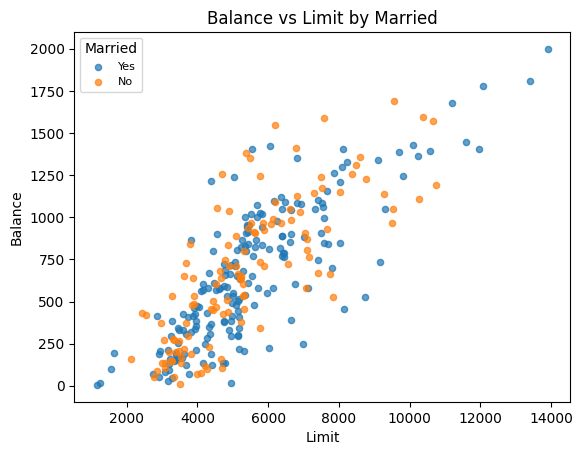


=== Scatterplots of Balance vs numeric predictors by Ethnicity ===


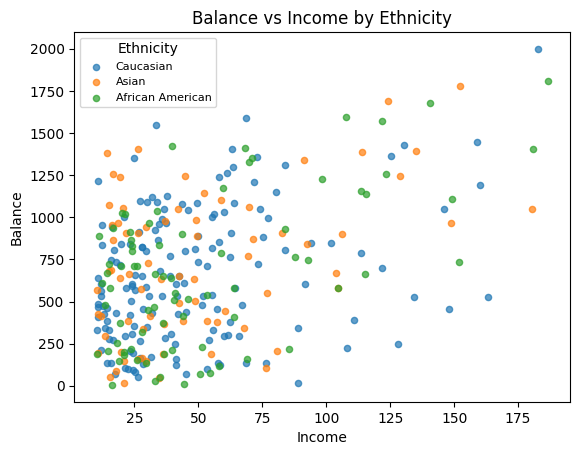

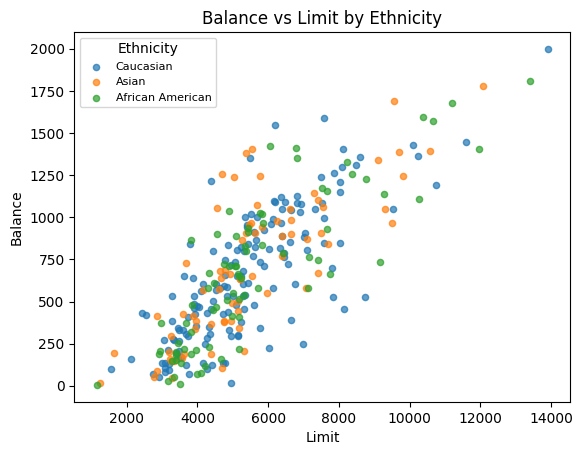

In [13]:
numeric_predictors = [c for c in numeric_cols if c != RESPONSE]

for cat in categorical_cols:
    levels = df_pos[cat].dropna().unique().tolist()
    print(f"\n=== Scatterplots of {RESPONSE} vs numeric predictors by {cat} ===")
    for num in numeric_predictors:
        for lvl in levels:
            sub = df_pos[df_pos[cat] == lvl]
            plt.scatter(sub[num], sub[RESPONSE], label=str(lvl), alpha=0.7, s=20)
        plt.xlabel(num)
        plt.ylabel(RESPONSE)
        plt.title(f"{RESPONSE} vs {num} by {cat}")
        plt.legend(title=cat, fontsize=8)
        plt.show()

Scatterplots grouped by categorical variables show student status is linked to higher credit balances for
comparable predictor values, but gender, marital status, and ethnicity do not demonstrate substantial differences
in Balance.

In [14]:
categorical_cols = [c for c in categorical_cols if c not in ['Gender', 'Married', 'Ethnicity']]
categorical_cols

['Student']

In [15]:
corr = df_pos[numeric_cols].corr()
print("\n=== Relationship between Balance and numeric predictors ===")
resp_corr = corr[RESPONSE].drop(index=RESPONSE)
print(resp_corr.sort_values(ascending=False).round(3))

print("\n=== Balance by categorical levels (group means) ===")
for c in categorical_cols:
    means = df_pos.groupby(c)[RESPONSE].mean().sort_values(ascending=False)
    print(f"\n{c}:")
    print(means.round(2))

print("\n=== Strong correlations among predictors (|r| >= 0.7) ===")
pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        r = corr.iloc[i, j]
        if abs(r) >= 0.7:
            pairs.append((numeric_cols[i], numeric_cols[j], r))
if pairs:
    for a, b, r in sorted(pairs, key=lambda x: -abs(x[2])):
        print(f"{a} — {b}: r = {r:.3f}")
else:
    print("No strong correlations found.")


=== Relationship between Balance and numeric predictors ===
Limit     0.796
Income    0.414
Name: Balance, dtype: float64

=== Balance by categorical levels (group means) ===

Student:
Student
Yes    899.31
No     638.13
Name: Balance, dtype: float64

=== Strong correlations among predictors (|r| >= 0.7) ===
Income — Limit: r = 0.834
Limit — Balance: r = 0.796


To Check need of transformation

In [16]:
print("\n=== Skewness (|skew| > 1 suggests log transformation) ===")
log_candidates = []
for c in numeric_cols:
    sk = skew(df_pos[c], nan_policy="omit")
    print(f"{c}: skew = {sk:.3f}")
    if abs(sk) > 1:
        log_candidates.append(c)

if log_candidates:
    print("\nVariables suggested for log transform:", log_candidates)
else:
    print("No strong skew detected; log transform not needed.")


=== Skewness (|skew| > 1 suggests log transformation) ===
Income: skew = 1.479
Limit: skew = 1.103
Balance: skew = 0.465

Variables suggested for log transform: ['Income', 'Limit']


In [17]:
df_pos["log_Income"] = np.log(df_pos["Income"])
df_pos["log_Limit"]  = np.log(df_pos["Limit"])


=== Balance vs original and log-transformed predictors ===


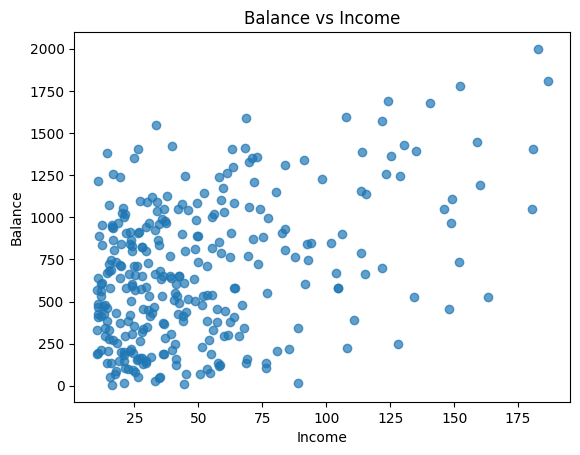

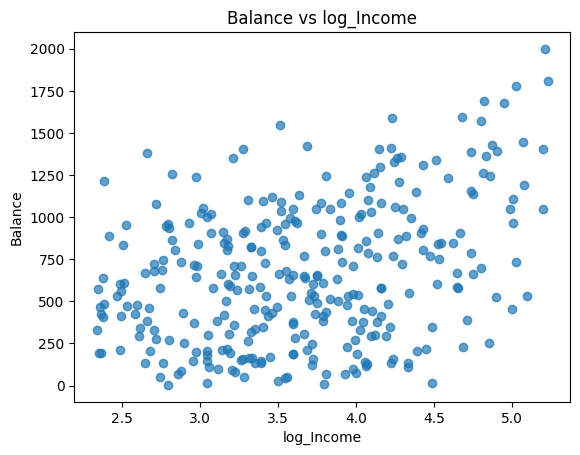

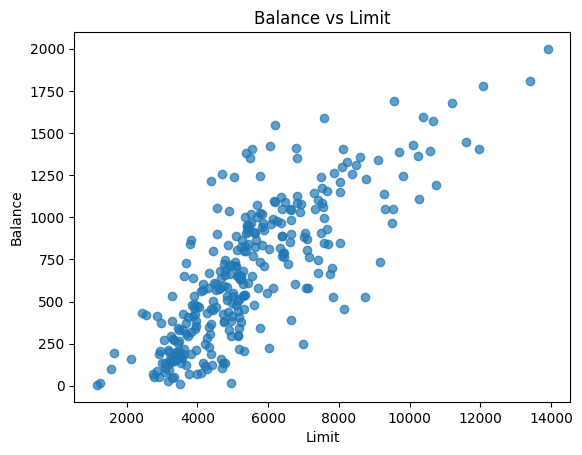

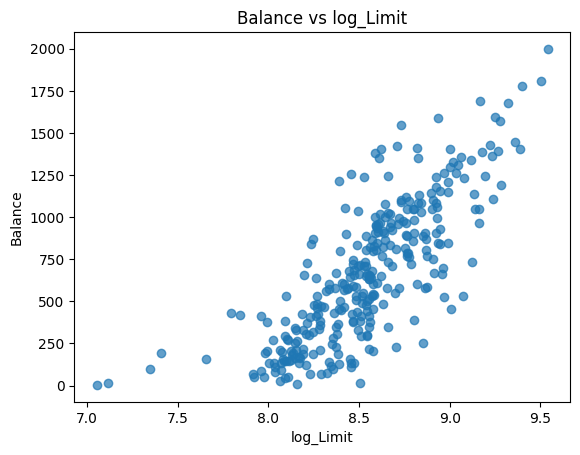

In [18]:
print("\n=== Balance vs original and log-transformed predictors ===")
for v in numeric_predictors:
    plt.scatter(df_pos[v], df_pos[RESPONSE], alpha=0.7)
    plt.xlabel(v)
    plt.ylabel(RESPONSE)
    plt.title(f"{RESPONSE} vs {v}")
    plt.show()

    log_name = f"log_{v}"
    plt.scatter(df_pos[log_name], df_pos[RESPONSE], alpha=0.7)
    plt.xlabel(log_name)
    plt.ylabel(RESPONSE)
    plt.title(f"{RESPONSE} vs {log_name}")
    plt.show()


To Check Transformation of Response variable

In [19]:
def diagnose_model(model, title_prefix="Model"):
    resid = model.resid
    fitted = model.fittedvalues

    # Residuals vs Fitted
    plt.figure(figsize=(6,4))
    sns.residplot(x=fitted, y=resid, lowess=True,
              scatter_kws={'alpha':0.6})
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.show()

    # QQ plot
    sm.qqplot(resid, line='45',fit=True)
    plt.title(f"{title_prefix}: QQ Plot")
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=30)
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.title(f"{title_prefix}: Histogram of Residuals")
    plt.show()

    # Heteroskedasticity tests
    exog = model.model.exog
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(resid, exog)
    white_stat, white_pvalue, _, _ = het_white(resid, exog)

    print(f"{title_prefix}: Breusch–Pagan p-value = {bp_pvalue:.3e}")
    print(f"{title_prefix}: White test p-value     = {white_pvalue:.3e}")

    #VIF
    X = model.model.exog
    vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    print("\nVariance Inflation Factors (VIF):")
    for name, v in zip(model.model.exog_names, vif):
        print(f"{name}: {v:.3f}")


Base Model Check

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     827.2
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          2.08e-146
Time:                        22:54:27   Log-Likelihood:                -1964.9
No. Observations:                 310   AIC:                             3938.
Df Residuals:                     306   BIC:                             3953.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.033e+04    232.23

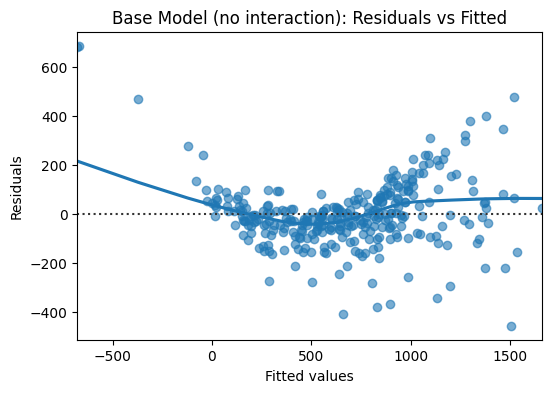

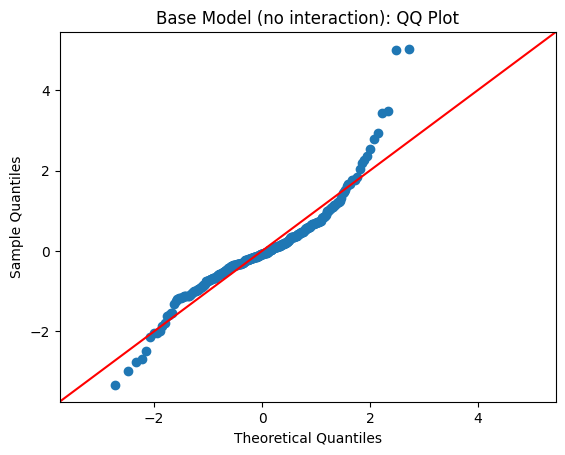

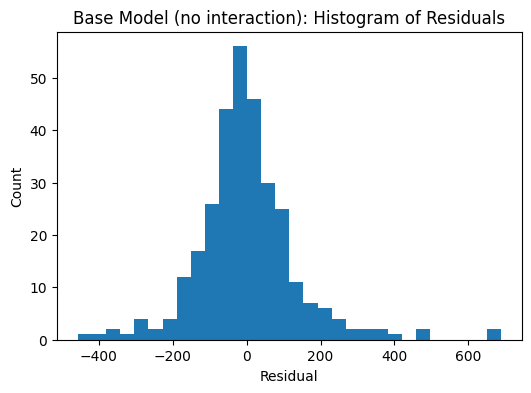

Base Model (no interaction): Breusch–Pagan p-value = 2.801e-10
Base Model (no interaction): White test p-value     = 2.029e-42

Variance Inflation Factors (VIF):
Intercept: 880.359
C(Student)[T.Yes]: 1.070
log_Income: 2.163
log_Limit: 2.245


In [20]:
base_formula_no_int = "Balance ~ log_Income + log_Limit + C(Student)"
base_model_no_int = smf.ols(base_formula_no_int, data=df_pos).fit()
print(base_model_no_int.summary())
diagnose_model(base_model_no_int, "Base Model (no interaction)")

Box Cox Transformation

Box–Cox MLE lambda for Balance (no-interaction model): 0.5668346850383332


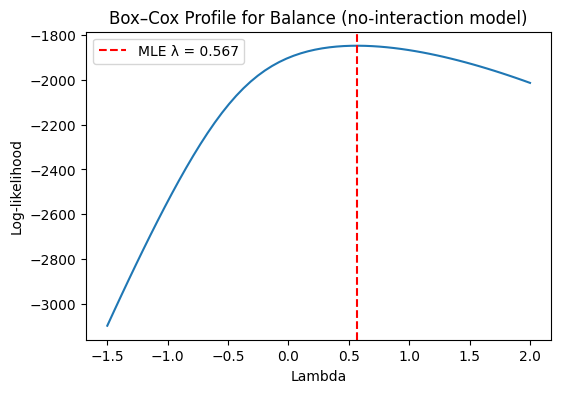

                            OLS Regression Results                            
Dep. Variable:             BC_Balance   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1141.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          9.88e-166
Time:                        22:54:28   Log-Likelihood:                -1064.9
No. Observations:                 310   AIC:                             2138.
Df Residuals:                     306   BIC:                             2153.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -656.5011     12.73

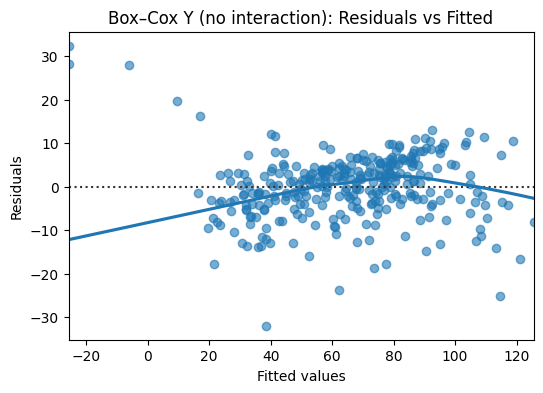

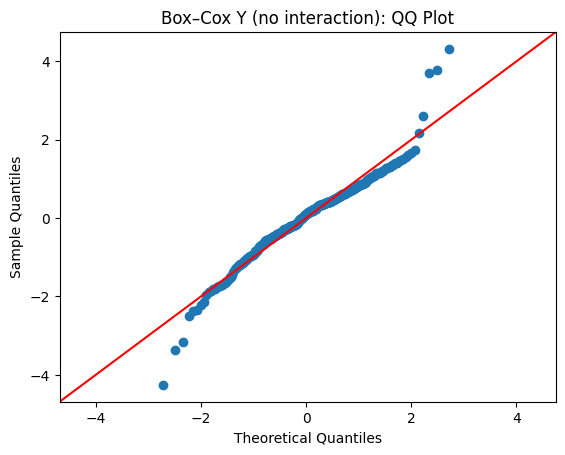

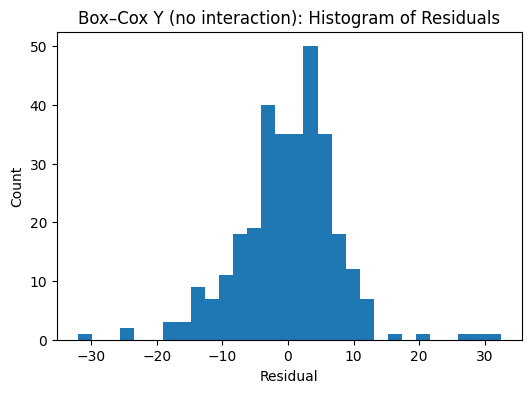

Box–Cox Y (no interaction): Breusch–Pagan p-value = 1.146e-14
Box–Cox Y (no interaction): White test p-value     = 4.765e-34

Variance Inflation Factors (VIF):
Intercept: 880.359
C(Student)[T.Yes]: 1.070
log_Income: 2.163
log_Limit: 2.245


In [21]:
y = df_pos["Balance"].to_numpy()

# Box–Cox transform & MLE lambda
y_bc, lambda_bc = stats.boxcox(y)
print("Box–Cox MLE lambda for Balance (no-interaction model):", lambda_bc)

# Profile log-likelihood
lambdas = np.linspace(-1.5, 2.0, 60)
llf = [stats.boxcox_llf(l, y) for l in lambdas]

plt.figure(figsize=(6,4))
plt.plot(lambdas, llf)
plt.axvline(lambda_bc, color="red", linestyle="--", label=f"MLE λ = {lambda_bc:.3f}")
plt.xlabel("Lambda")
plt.ylabel("Log-likelihood")
plt.title("Box–Cox Profile for Balance (no-interaction model)")
plt.legend()
plt.show()

# Fit model with Box–Cox-transformed Balance
df_pos["BC_Balance"] = y_bc
bc_formula_no_int = "BC_Balance ~ log_Income + log_Limit + C(Student)"
bc_model_no_int = smf.ols(bc_formula_no_int, data=df_pos).fit()
print(bc_model_no_int.summary())

diagnose_model(bc_model_no_int, "Box–Cox Y (no interaction)")

Inverse Fitted Value

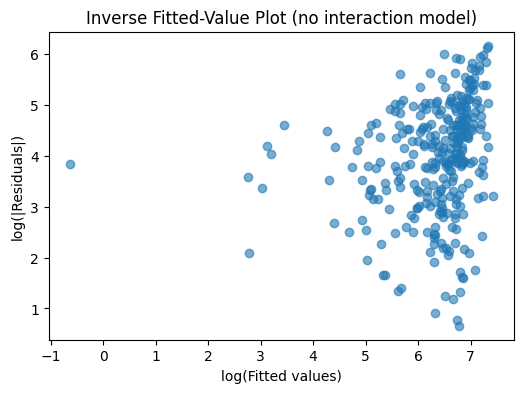

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     14.07
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           0.000211
Time:                        22:54:28   Log-Likelihood:                -451.01
No. Observations:                 302   AIC:                             906.0
Df Residuals:                     300   BIC:                             913.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2903      0.450      5.094      0.0

In [22]:
fitted_base = base_model_no_int.fittedvalues.to_numpy()
resid_base = base_model_no_int.resid.to_numpy()

# Use only positive fitted values (they should all be, but to be safe)
mask = fitted_base > 0
fitted_pos = fitted_base[mask]
resid_pos = resid_base[mask]

log_fitted = np.log(fitted_pos)
log_abs_resid = np.log(np.abs(resid_pos))

# Scatterplot: inverse fitted-value plot
plt.figure(figsize=(6,4))
plt.scatter(log_fitted, log_abs_resid, alpha=0.6)
plt.xlabel("log(Fitted values)")
plt.ylabel("log(|Residuals|)")
plt.title("Inverse Fitted-Value Plot (no interaction model)")
plt.show()

# Regress log(|resid|) on log(fitted)
X_inv = sm.add_constant(log_fitted)
inv_fit_no_int = sm.OLS(log_abs_resid, X_inv).fit()
print(inv_fit_no_int.summary())

slope = inv_fit_no_int.params[1]  # slope for log_fitted
lambda_inv = 1 - 2 * slope             # rule used in your class
print(f"Inverse-fitted suggested lambda for Balance (no interactions): {lambda_inv:.3f}")

Log Transformation

                            OLS Regression Results                            
Dep. Variable:            log_Balance   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     512.5
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          6.07e-119
Time:                        22:54:28   Log-Likelihood:                -134.93
No. Observations:                 310   AIC:                             277.9
Df Residuals:                     306   BIC:                             292.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -18.3860      0.63

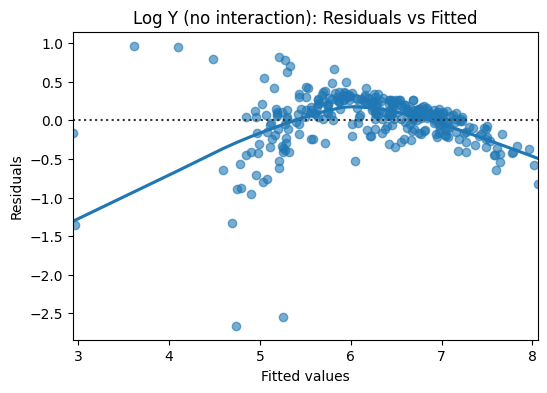

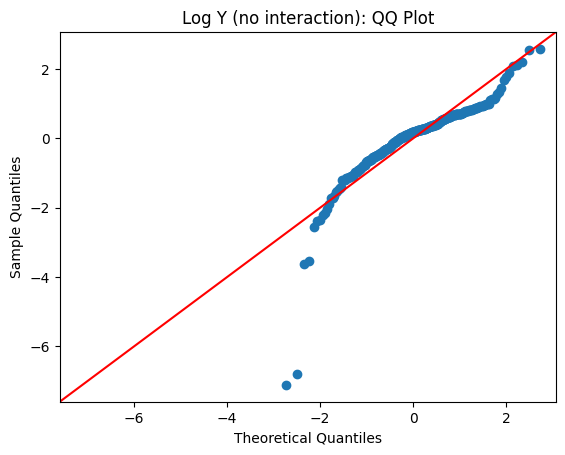

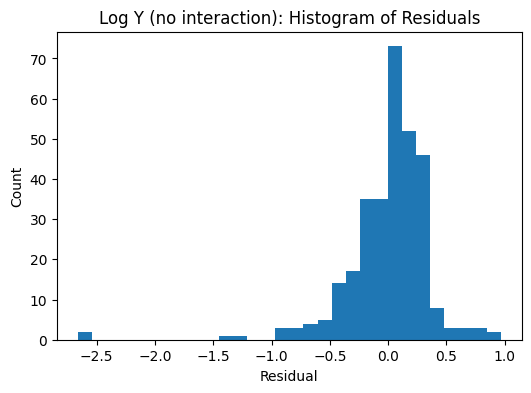

Log Y (no interaction): Breusch–Pagan p-value = 3.635e-06
Log Y (no interaction): White test p-value     = 1.127e-07

Variance Inflation Factors (VIF):
Intercept: 880.359
C(Student)[T.Yes]: 1.070
log_Income: 2.163
log_Limit: 2.245


In [23]:
df_pos["log_Balance"] = np.log(df_pos["Balance"])

logY_formula_no_int = "log_Balance ~ log_Income + log_Limit + C(Student)"
logY_model_no_int = smf.ols(logY_formula_no_int, data=df_pos).fit()
print(logY_model_no_int.summary())

diagnose_model(logY_model_no_int, "Log Y (no interaction)")

SQRT Tranformation

                            OLS Regression Results                            
Dep. Variable:           sqrt_Balance   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1136.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          1.76e-165
Time:                        22:54:29   Log-Likelihood:                -722.27
No. Observations:                 310   AIC:                             1453.
Df Residuals:                     306   BIC:                             1467.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -214.6593      4.21

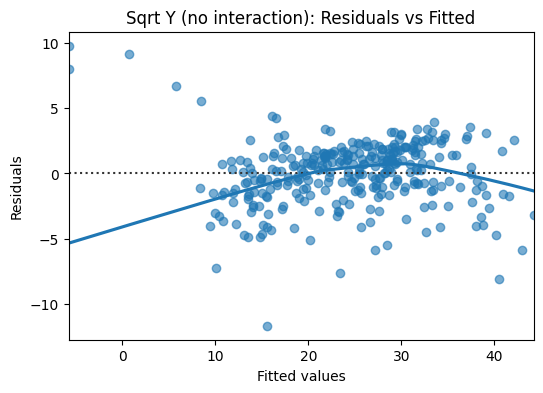

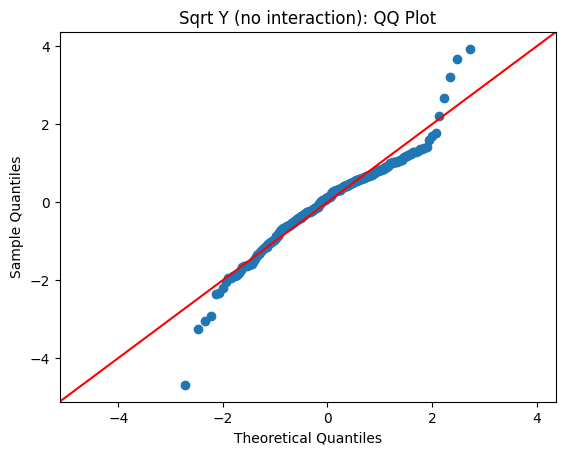

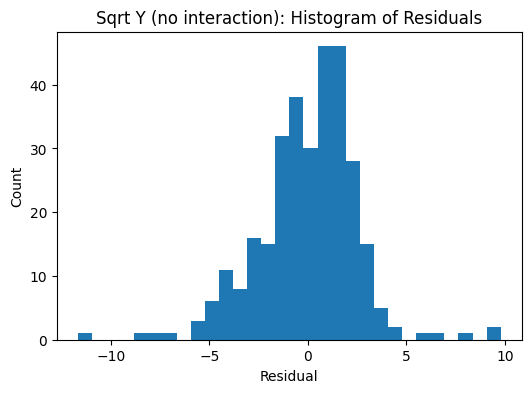

Sqrt Y (no interaction): Breusch–Pagan p-value = 3.107e-14
Sqrt Y (no interaction): White test p-value     = 1.480e-28

Variance Inflation Factors (VIF):
Intercept: 880.359
C(Student)[T.Yes]: 1.070
log_Income: 2.163
log_Limit: 2.245


In [24]:
df_pos["sqrt_Balance"] = np.sqrt(df_pos["Balance"])

sqrtY_formula_no_int = "sqrt_Balance ~ log_Income + log_Limit + C(Student)"
sqrtY_model_no_int = smf.ols(sqrtY_formula_no_int, data=df_pos).fit()
print(sqrtY_model_no_int.summary())

diagnose_model(sqrtY_model_no_int, "Sqrt Y (no interaction)")

Based on the Box–Cox method, inverse fitted-value plot, log transformation, and
square-root transformation applied to the
response variable Balance, none of the transformations provided meaningful improvement in model diagnostics.

Although Box–Cox suggested λ ≈ 0.57 and both Box–Cox and square-root transformations slightly increased R², all
transformed models continued to show strong heteroscedasticity, clear curvature in the residuals, and substantial
deviations from normality in the QQ-plots. Log transformation performed the worst, reducing model fit and worsening
distributional assumptions. The inverse fitted-value method also showed no strong evidence supporting a power
transformation.

Because all transformations failed to correct the major model violations, and the diagnostic patterns remained largely
unchanged, the transformations did not offer practical improvement over using the original response variable.

Therefore, for the remainder of this analysis, the response variable will be kept as simple, untransformed Balance (Y).

This choice maintains interpretability and avoids unnecessary transformation, while model issues will instead be addressed
using other remedies such as adding interaction terms.

**Model Selection**

AIC/BIC Based subset selection to identify the most statistically efficient Model

In [25]:
predictors = ['log_Income', 'log_Limit', 'C(Student)']

# Build all subsets: powerset
models = []
for k in range(1, len(predictors)+1):
    for combo in itertools.combinations(predictors, k):
        formula = "Balance ~ " + " + ".join(combo)
        model = smf.ols(formula, data=df_pos).fit()
        models.append((formula, model.aic, model.bic))

# Sort by AIC
models_sorted = sorted(models, key=lambda x: x[1])

print("\n===== STEPWISE-LIKE BEST AIC MODELS =====")
for m in models_sorted:
    print(f"Model: {m[0]}")
    print(f"AIC: {m[1]:.3f}, BIC: {m[2]:.3f}")
    print("-" * 40)


===== STEPWISE-LIKE BEST AIC MODELS =====
Model: Balance ~ log_Income + log_Limit + C(Student)
AIC: 3937.745, BIC: 3952.691
----------------------------------------
Model: Balance ~ log_Limit + C(Student)
AIC: 4189.790, BIC: 4201.000
----------------------------------------
Model: Balance ~ log_Income + log_Limit
AIC: 4238.566, BIC: 4249.776
----------------------------------------
Model: Balance ~ log_Limit
AIC: 4321.981, BIC: 4329.454
----------------------------------------
Model: Balance ~ log_Income + C(Student)
AIC: 4560.874, BIC: 4572.084
----------------------------------------
Model: Balance ~ log_Income
AIC: 4576.165, BIC: 4583.638
----------------------------------------
Model: Balance ~ C(Student)
AIC: 4604.706, BIC: 4612.179
----------------------------------------


Model with Log_Income, Log_Limit, and student is best choice as, it contain less AIC/BIC as compare to other model

Cross Validated RMSE Evaluation to determine the model with the strong predictive accuracy

In [26]:
def cv_rmse(formula, data, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    rmses = []
    for train_index, test_index in kf.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model = smf.ols(formula, data=train).fit()
        preds = model.predict(test)
        rmse = np.sqrt(mean_squared_error(test['Balance'], preds))
        rmses.append(rmse)
    return np.mean(rmses)

models_to_test = {
    "Model A: log_Income": "Balance ~ log_Income",
    "Model B: log_Income + log_Limit": "Balance ~ log_Income + log_Limit",
    "Model C: Full Model": "Balance ~ log_Income + log_Limit + C(Student)"
}

print("\n===== CROSS-VALIDATED RMSE (10-Fold) =====")
for name, formula in models_to_test.items():
    rmse = cv_rmse(formula, df_pos, k=10)
    print(f"{name} --> CV RMSE = {rmse:.2f}")


===== CROSS-VALIDATED RMSE (10-Fold) =====
Model A: log_Income --> CV RMSE = 385.66
Model B: log_Income + log_Limit --> CV RMSE = 225.19
Model C: Full Model --> CV RMSE = 138.33


Model C with Log_Income, Log_Limit and Student have less RMSE as compare to other models. MOdel C perform Well

Final Model: **Balance ~ log_Income + log_Limit + C(Student)**

Do not need to check once again model assumption, as we havn't deleted or added predictor in our model

**Model Interpretation**

In [27]:
anova_results = anova_lm(base_model_no_int)
print("ANOVA Table for Final Model:\n")
print(anova_results)

ANOVA Table for Final Model:

               df        sum_sq       mean_sq            F         PR(>F)
C(Student)    1.0  2.325665e+06  2.325665e+06   122.463021   3.629611e-24
log_Income    1.0  6.955746e+06  6.955746e+06   366.270117   3.094577e-54
log_Limit     1.0  3.784423e+07  3.784423e+07  1992.771175  4.966576e-136
Residual    306.0  5.811171e+06  1.899075e+04          NaN            NaN


In [28]:
print("\n=== Percentage Change Effects ===")

coef_inc = base_model_no_int.params['log_Income']
coef_lim = base_model_no_int.params['log_Limit']

print(f"Effect of 1% increase in Income: {coef_inc * 0.01:.4f} change in Balance")
print(f"Effect of 1% increase in Limit (Non-students): {coef_lim * 0.01:.4f} change in Balance")



=== Percentage Change Effects ===
Effect of 1% increase in Income: -3.1745 change in Balance
Effect of 1% increase in Limit (Non-students): 14.1592 change in Balance


In [29]:
#Predict balance for Students vs Non-students at average values

avg_income = df_pos['Income'].mean()
avg_limit = df_pos['Limit'].mean()

test_df = pd.DataFrame({
    'log_Income': [np.log(avg_income), np.log(avg_income)],
    'log_Limit': [np.log(avg_limit), np.log(avg_limit)],
    'Student': ['No', 'Yes']
})

preds = base_model_no_int.predict(test_df)

print("\n=== Predicted Balance at Average Income/Limit ===")
print(f"Non-Student: ${preds.iloc[0]:.2f}")
print(f"Student:     ${preds.iloc[1]:.2f}")
print(f"Difference (Student – Non-Student): ${preds.iloc[1] - preds.iloc[0]:.2f}")



=== Predicted Balance at Average Income/Limit ===
Non-Student: $615.25
Student:     $1164.93
Difference (Student – Non-Student): $549.68


In [30]:
# Pairwise Comparison for Student Levels
tukey_student = pairwise_tukeyhsd(
    endog=df_pos["Balance"],
    groups=df_pos["Student"],
    alpha=0.05
)

print("\n=== Pairwise Comparison for Student (Tukey HSD) ===")
print(tukey_student)


=== Pairwise Comparison for Student (Tukey HSD) ===
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    No    Yes 261.1785 0.0002 124.5726 397.7845   True
------------------------------------------------------


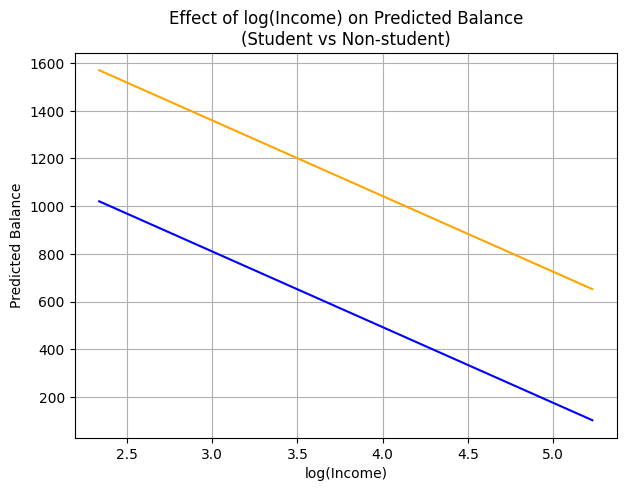

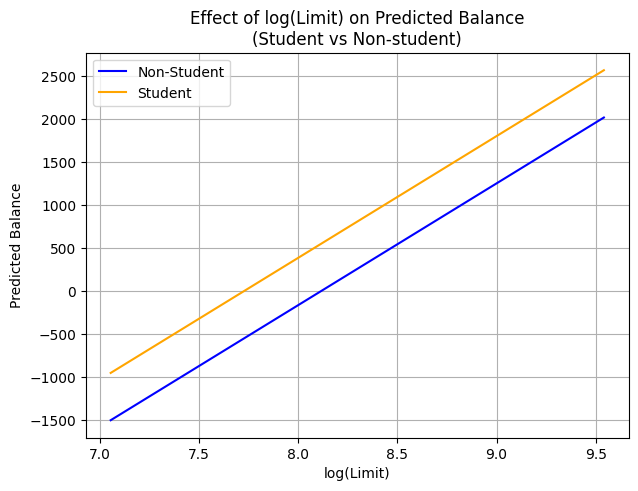

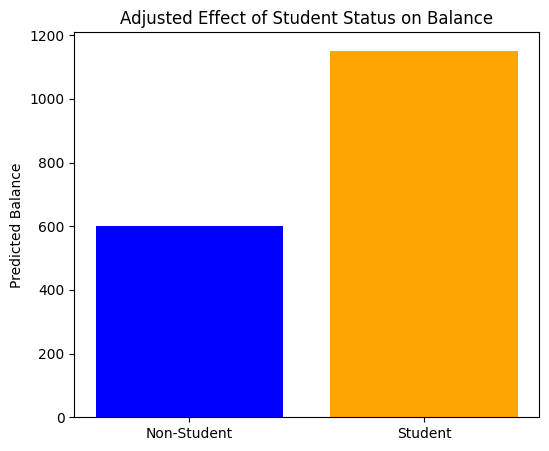

In [31]:
# EFFECT PLOTS FOR FINAL MODEL

# Create ranges for log(Income) and log(Limit)
log_income_range = np.linspace(df_pos['log_Income'].min(), df_pos['log_Income'].max(), 100)
log_limit_range = np.linspace(df_pos['log_Limit'].min(), df_pos['log_Limit'].max(), 100)

avg_income = df_pos['log_Income'].mean()
avg_limit = df_pos['log_Limit'].mean()


# -------------------------------
# 1. Effect of log(Income) for Students Vs Non-Student
# -------------------------------

#Non-Student
pred_df_inc_no = pd.DataFrame({
    'log_Income': log_income_range,
    'log_Limit': avg_limit,
    'Student': ['No'] * 100
})
pred_df_inc_no['Pred'] = base_model_no_int.predict(pred_df_inc_no)

#Student
pred_df_inc_yes = pd.DataFrame({
    'log_Income': log_income_range,
    'log_Limit': avg_limit,
    'Student': ['Yes'] * 100
})
pred_df_inc_yes['Pred'] = base_model_no_int.predict(pred_df_inc_yes)

plt.figure(figsize=(7,5))
plt.plot(log_income_range, pred_df_inc_no['Pred'], label="Non-Student", color='blue')
plt.plot(log_income_range, pred_df_inc_yes['Pred'], label="Student", color='orange')
plt.title("Effect of log(Income) on Predicted Balance\n(Student vs Non-student)")
plt.xlabel("log(Income)")
plt.ylabel("Predicted Balance")
plt.grid(True)
plt.show()


# -------------------------------
# 2. Effect of log(Limit) for Students vs Non-students
# -------------------------------

# Non-student
pred_df_lim_no = pd.DataFrame({
    'log_Income': avg_income,
    'log_Limit': log_limit_range,
    'Student': ['No'] * 100
})
pred_df_lim_no['Pred'] = base_model_no_int.predict(pred_df_lim_no)

# Student
pred_df_lim_yes = pd.DataFrame({
    'log_Income': avg_income,
    'log_Limit': log_limit_range,
    'Student': ['Yes'] * 100
})
pred_df_lim_yes['Pred'] = base_model_no_int.predict(pred_df_lim_yes)

plt.figure(figsize=(7,5))
plt.plot(log_limit_range, pred_df_lim_no['Pred'], label="Non-Student", color='blue')
plt.plot(log_limit_range, pred_df_lim_yes['Pred'], label="Student", color='orange')
plt.title("Effect of log(Limit) on Predicted Balance\n(Student vs Non-student)")
plt.xlabel("log(Limit)")
plt.ylabel("Predicted Balance")
plt.legend()
plt.grid(True)
plt.show()


# -------------------------------
# 3. Effect of Student (adjusted means)
# -------------------------------

pred_student = pd.DataFrame({
    'log_Income': [avg_income, avg_income],
    'log_Limit': [avg_limit, avg_limit],
    'Student': ['No','Yes']
})
pred_student['Pred'] = base_model_no_int.predict(pred_student)

plt.figure(figsize=(6,5))
plt.bar(['Non-Student','Student'], pred_student['Pred'], color=['blue','orange'])
plt.title("Adjusted Effect of Student Status on Balance")
plt.ylabel("Predicted Balance")
plt.show()

**Interaction Term**

In [32]:
model_inc_int = smf.ols(
    "Balance ~ log_Income*C(Student) + log_Limit",
    data=df_pos
).fit()

print(model_inc_int.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     688.6
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          2.75e-151
Time:                        22:54:31   Log-Likelihood:                -1949.9
No. Observations:                 310   AIC:                             3910.
Df Residuals:                     305   BIC:                             3929.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [33]:
model_lim_int = smf.ols(
    "Balance ~ log_Limit*C(Student) + log_Income",
    data=df_pos
).fit()

print(model_lim_int.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     927.3
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          2.87e-169
Time:                        22:54:31   Log-Likelihood:                -1907.8
No. Observations:                 310   AIC:                             3826.
Df Residuals:                     305   BIC:                             3844.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

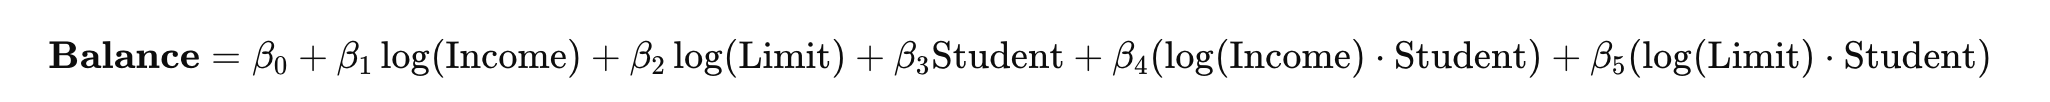

In [34]:
final_formula_1 = """
Balance ~ log_Income*C(Student) + log_Limit*C(Student)
"""

final_model_1 = smf.ols(final_formula_1, data=df_pos).fit()
print(final_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     748.3
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          1.74e-168
Time:                        22:54:31   Log-Likelihood:                -1906.1
No. Observations:                 310   AIC:                             3824.
Df Residuals:                     304   BIC:                             3847.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Interaction between income and student is not statistically significant, so removing from final model

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     927.3
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          2.87e-169
Time:                        22:54:31   Log-Likelihood:                -1907.8
No. Observations:                 310   AIC:                             3826.
Df Residuals:                     305   BIC:                             3844.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

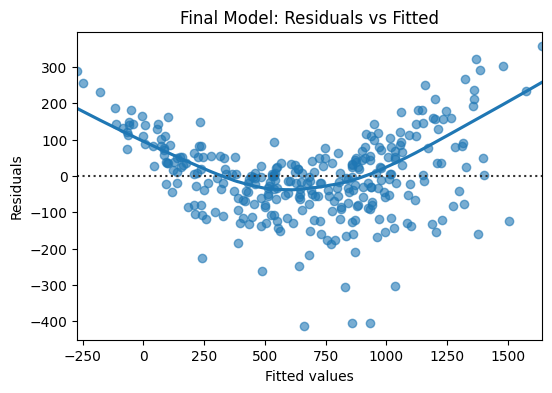

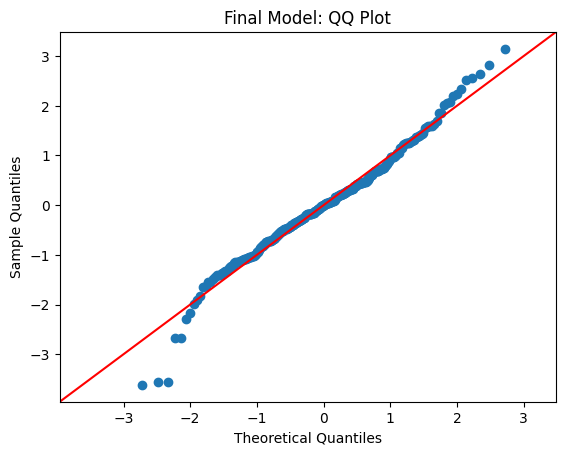

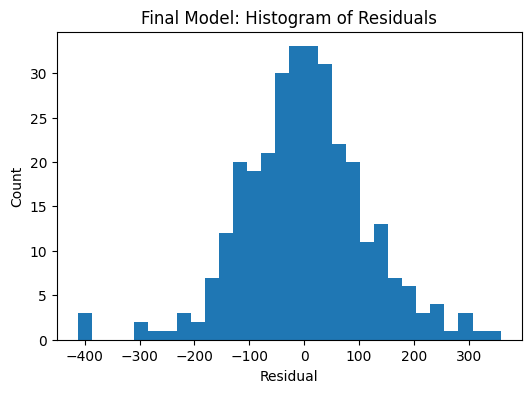

Final Model: Breusch–Pagan p-value = 8.352e-09
Final Model: White test p-value     = 2.295e-20

Variance Inflation Factors (VIF):
Intercept: 1252.212
C(Student)[T.Yes]: 329.888
log_Income: 2.313
log_Limit: 3.087
log_Limit:C(Student)[T.Yes]: 324.204


In [35]:
final_formula = """
Balance ~ log_Income + log_Limit + C(Student) + log_Limit:C(Student)
"""

final_model = smf.ols(final_formula, data=df_pos).fit()
print(final_model.summary())
diagnose_model(final_model, title_prefix="Final Model")

In [36]:
#AIC/BIC

main_terms = ['log_Income', 'log_Limit', 'C(Student)']

# Only interaction you allow
interaction_term = 'log_Limit:C(Student)'

all_terms = main_terms + [interaction_term]

models_int = []

for k in range(1, len(all_terms) + 1):
    for combo in itertools.combinations(all_terms, k):
        combo = list(combo)

        # --- Hierarchy rule: if interaction is included,
        #     both log_Limit and C(Student) must be in the model ---
        if interaction_term in combo:
            if ('log_Limit' not in combo) or ('C(Student)' not in combo):
                continue

        # Build formula
        formula = "Balance ~ " + " + ".join(combo)

        # Fit model (use df_pos instead of df_clean if you prefer)
        model = smf.ols(formula, data=df_pos).fit()
        models_int.append((formula, model.aic, model.bic))

# Sort by AIC (change key to x[2] if you want best BIC instead)
models_int_sorted = sorted(models_int, key=lambda x: x[1])

print("\n===== BEST AIC MODELS WITH log_Limit:C(Student) OPTION =====")
for m in models_int_sorted[:10]:   # top 10 models
    print(f"Model: {m[0]}")
    print(f"AIC: {m[1]:.3f}, BIC: {m[2]:.3f}")
    print("-" * 40)


===== BEST AIC MODELS WITH log_Limit:C(Student) OPTION =====
Model: Balance ~ log_Income + log_Limit + C(Student) + log_Limit:C(Student)
AIC: 3825.670, BIC: 3844.353
----------------------------------------
Model: Balance ~ log_Income + log_Limit + C(Student)
AIC: 3937.745, BIC: 3952.691
----------------------------------------
Model: Balance ~ log_Limit + C(Student) + log_Limit:C(Student)
AIC: 4183.202, BIC: 4198.149
----------------------------------------
Model: Balance ~ log_Limit + C(Student)
AIC: 4189.790, BIC: 4201.000
----------------------------------------
Model: Balance ~ log_Income + log_Limit
AIC: 4238.566, BIC: 4249.776
----------------------------------------
Model: Balance ~ log_Limit
AIC: 4321.981, BIC: 4329.454
----------------------------------------
Model: Balance ~ log_Income + C(Student)
AIC: 4560.874, BIC: 4572.084
----------------------------------------
Model: Balance ~ log_Income
AIC: 4576.165, BIC: 4583.638
----------------------------------------
Model: Bal

Model with Interaction term is best, as it has less AIC/BIC value as compare to other models

In [37]:
#cross validated RMSE
models_to_test = {
    "Model A: log_Income": "Balance ~ log_Income",
    "Model B: log_Income + log_Limit": "Balance ~ log_Income + log_Limit",
    "Model C: Full Model WO I": "Balance ~ log_Income + log_Limit + C(Student)",
    "Model D: Full Interaction Model": "Balance ~ log_Income + log_Limit + C(Student) + log_Limit:C(Student)"
}

print("\n===== CROSS-VALIDATED RMSE (10-Fold) =====")
for name, formula in models_to_test.items():
    rmse = cv_rmse(formula, df_pos, k=10)
    print(f"{name} --> CV RMSE = {rmse:.2f}")


===== CROSS-VALIDATED RMSE (10-Fold) =====
Model A: log_Income --> CV RMSE = 385.66
Model B: log_Income + log_Limit --> CV RMSE = 225.19
Model C: Full Model WO I --> CV RMSE = 138.33
Model D: Full Interaction Model --> CV RMSE = 114.94


Model D with Log_Income, Log_Limit, Student and interaction term have less RMSE as compare to other models. MOdel D perform Well

In [38]:
anova_results = anova_lm(final_model)
print("ANOVA Table for Final Model:\n")
print(anova_results)

ANOVA Table for Final Model:

                         df        sum_sq       mean_sq            F  \
C(Student)              1.0  2.325665e+06  2.325665e+06   176.358661   
log_Income              1.0  6.955746e+06  6.955746e+06   527.464591   
log_Limit               1.0  3.784423e+07  3.784423e+07  2869.784303   
log_Limit:C(Student)    1.0  1.789095e+06  1.789095e+06   135.669761   
Residual              305.0  4.022076e+06  1.318713e+04          NaN   

                             PR(>F)  
C(Student)             4.511199e-32  
log_Income             1.809888e-68  
log_Limit             3.353688e-157  
log_Limit:C(Student)   3.472000e-26  
Residual                        NaN  


In [39]:
print("\n=== Percentage Change Effects ===")

coef_inc = final_model.params['log_Income']
coef_lim = final_model.params['log_Limit']

print(f"Effect of 1% increase in Income: {coef_inc * 0.01:.4f} change in Balance")
print(f"Effect of 1% increase in Limit (Non-students): {coef_lim * 0.01:.4f} change in Balance")



=== Percentage Change Effects ===
Effect of 1% increase in Income: -3.5870 change in Balance
Effect of 1% increase in Limit (Non-students): 16.0448 change in Balance


In [40]:
#Predict balance for Students vs Non-students at average values

avg_income = df_pos['Income'].mean()
avg_limit = df_pos['Limit'].mean()

test_df = pd.DataFrame({
    'log_Income': [np.log(avg_income), np.log(avg_income)],
    'log_Limit': [np.log(avg_limit), np.log(avg_limit)],
    'Student': ['No', 'Yes']
})

preds = final_model.predict(test_df)

print("\n=== Predicted Balance at Average Income/Limit ===")
print(f"Non-Student: ${preds.iloc[0]:.2f}")
print(f"Student:     ${preds.iloc[1]:.2f}")
print(f"Difference (Student – Non-Student): ${preds.iloc[1] - preds.iloc[0]:.2f}")



=== Predicted Balance at Average Income/Limit ===
Non-Student: $612.46
Student:     $1075.45
Difference (Student – Non-Student): $462.99


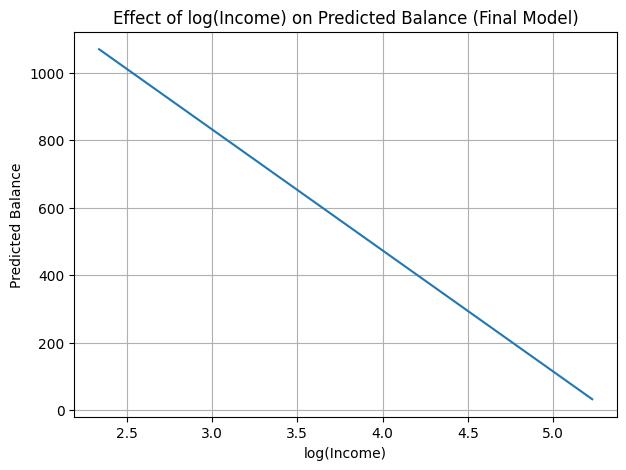

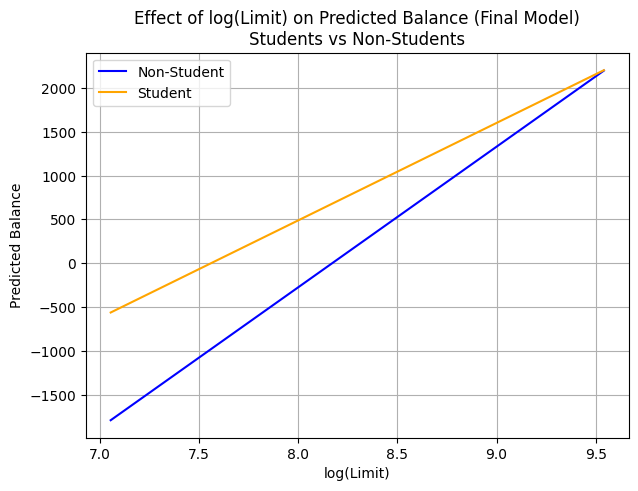

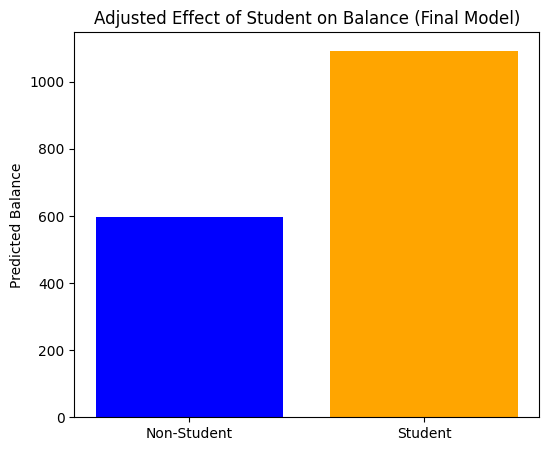

In [41]:
#Effect Plot
# Ranges for predictors
log_income_range_f = np.linspace(df_pos['log_Income'].min(), df_pos['log_Income'].max(), 100)
log_limit_range_f  = np.linspace(df_pos['log_Limit'].min(),  df_pos['log_Limit'].max(),  100)

avg_inc_f = df_pos['log_Income'].mean()
avg_lim_f = df_pos['log_Limit'].mean()


# ---------------------------------------------------
# 1. Effect of log(Income)
# ---------------------------------------------------
pred_df_inc_f = pd.DataFrame({
    'log_Income': log_income_range_f,
    'log_Limit': avg_lim_f,
    'Student': ['No'] * 100
})
pred_df_inc_f['Pred'] = final_model.predict(pred_df_inc_f)

plt.figure(figsize=(7,5))
plt.plot(log_income_range_f, pred_df_inc_f['Pred'])
plt.title("Effect of log(Income) on Predicted Balance (Final Model)")
plt.xlabel("log(Income)")
plt.ylabel("Predicted Balance")
plt.grid(True)
plt.show()


# ---------------------------------------------------
# 2. Effect of log(Limit) for Students vs Non-Students
# ---------------------------------------------------
pred_no = pd.DataFrame({
    'log_Income': avg_inc_f,
    'log_Limit': log_limit_range_f,
    'Student': ['No'] * 100
})
pred_no['Pred'] = final_model.predict(pred_no)

pred_yes = pd.DataFrame({
    'log_Income': avg_inc_f,
    'log_Limit': log_limit_range_f,
    'Student': ['Yes'] * 100
})
pred_yes['Pred'] = final_model.predict(pred_yes)

plt.figure(figsize=(7,5))
plt.plot(log_limit_range_f, pred_no['Pred'], label='Non-Student', color='blue')
plt.plot(log_limit_range_f, pred_yes['Pred'], label='Student', color='orange')
plt.title("Effect of log(Limit) on Predicted Balance (Final Model)\nStudents vs Non-Students")
plt.xlabel("log(Limit)")
plt.ylabel("Predicted Balance")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------
# 3. Adjusted Effect of Student
# ---------------------------------------------------
pred_student_f = pd.DataFrame({
    'log_Income': [avg_inc_f, avg_inc_f],
    'log_Limit':  [avg_lim_f, avg_lim_f],
    'Student':    ['No','Yes']
})
pred_student_f['Pred'] = final_model.predict(pred_student_f)

plt.figure(figsize=(6,5))
plt.bar(['Non-Student','Student'], pred_student_f['Pred'], color=['blue','orange'])
plt.title("Adjusted Effect of Student on Balance (Final Model)")
plt.ylabel("Predicted Balance")
plt.show()


**Influence Points and Outliers**

In [42]:
# Section H

# (h1) Identify the influential point again (for completeness)

influence = final_model.get_influence()
cooks_d, pvals = influence.cooks_distance
n = len(df_pos)

threshold = 4/n
infl_idx = np.where(cooks_d > threshold)[0]

print("Influential points:", infl_idx)
print("Cook's D values:", cooks_d[infl_idx])


Influential points: [  9  23  26  69  82  86  94 106 107 128 141 150 153 155 164 168 183 186
 189 197 202 210 213 223 243 246 283]
Cook's D values: [0.0199316  0.02909523 0.02013131 0.03846492 0.0687773  0.0145158
 0.04006496 0.0168283  0.0159685  0.01438254 0.17099607 0.03456436
 0.02102494 0.02428606 0.02079581 0.0254027  0.01714966 0.31758417
 0.04896891 0.04123457 0.013242   0.0448715  0.03719793 0.03022754
 0.27430173 0.07315983 0.02410737]


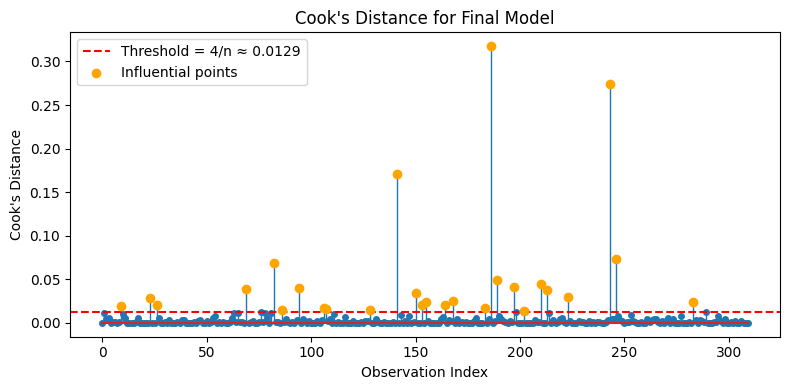

In [49]:
plt.figure(figsize=(8, 4))
x_idx = np.arange(n)

# stem-style plot for Cook's D
markerline, stemlines, baseline = plt.stem(x_idx, cooks_d)
plt.setp(markerline, markersize=4)
plt.setp(stemlines, linewidth=1)

# horizontal threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = 4/n ≈ {threshold:.4f}')

# optionally highlight influential points
plt.scatter(infl_idx, cooks_d[infl_idx], color='orange', zorder=3, label='Influential points')

plt.title("Cook's Distance for Final Model")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# (h2) Compute Prediction Intervals for those influential points

# extract the influential row(s)
infl_points = df_pos.iloc[infl_idx]

# Get prediction intervals for these points
pred_infl = final_model.get_prediction(infl_points)
pi_infl = pred_infl.summary_frame(alpha=0.05)

print("\n=== Prediction Intervals for Influential Points ===")
print(pi_infl[['obs_ci_lower', 'obs_ci_upper', 'mean', 'mean_ci_lower', 'mean_ci_upper']])



=== Prediction Intervals for Influential Points ===
    obs_ci_lower  obs_ci_upper         mean  mean_ci_lower  mean_ci_upper
0     959.927196   1422.428965  1191.178081    1142.038450    1240.317711
1    1344.940278   1804.201344  1574.570811    1533.730719    1615.410902
2     603.281248   1058.348854   830.815051     804.181181     857.448920
3    1248.633199   1706.511745  1477.572472    1440.817577    1514.327367
4    1088.842291   1553.496274  1321.169282    1267.191858    1375.146707
5     261.264779    716.264816   488.764797     462.421111     515.108484
6     631.745128   1087.189547   859.467338     831.269179     887.665496
7    1132.400313   1588.633032  1360.516673    1329.294808    1391.738537
8    1034.637263   1495.082394  1264.859828    1220.812570    1308.907087
9    1132.556482   1589.041326  1360.798904    1328.668938    1392.928870
10   1130.344303   1602.327138  1366.335721    1298.293964    1434.377477
11    968.990048   1431.340184  1200.165116    1151.383526 


=== Model WITHOUT influential point(s) ===
                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1245.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          4.53e-176
Time:                        22:54:33   Log-Likelihood:                -1657.8
No. Observations:                 283   AIC:                             3326.
Df Residuals:                     278   BIC:                             3344.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

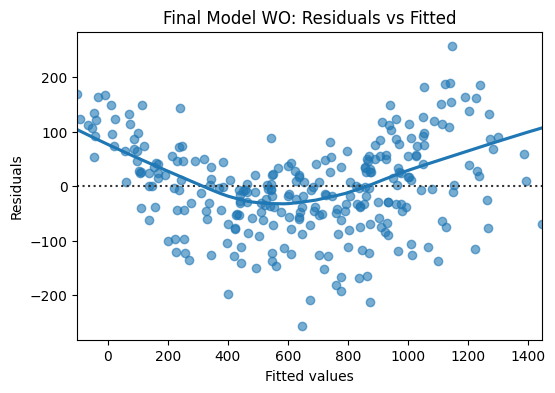

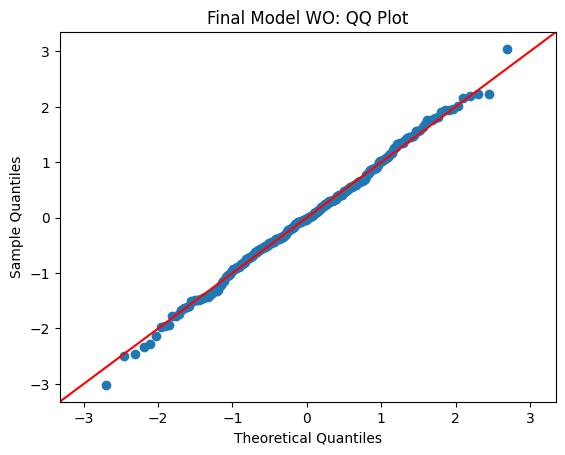

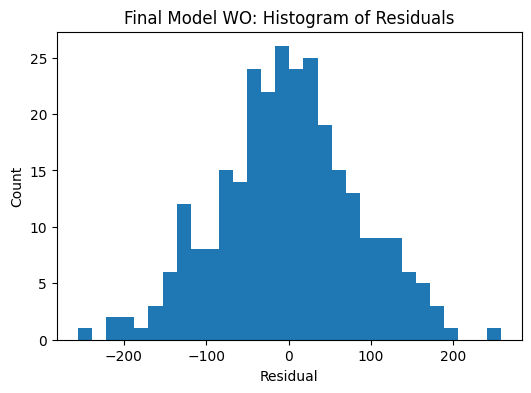

Final Model WO: Breusch–Pagan p-value = 3.959e-03
Final Model WO: White test p-value     = 9.022e-08

Variance Inflation Factors (VIF):
Intercept: 1323.774
C(Student)[T.Yes]: 632.487
log_Income: 2.081
log_Limit: 2.373
log_Limit:C(Student)[T.Yes]: 628.250


In [44]:
# (h3) Fit the model WITHOUT the influential point(s)

df_wo = df_pos.drop(df_pos.index[infl_idx]).reset_index(drop=True)

model_wo = smf.ols(final_formula, data=df_wo).fit()

print("\n=== Model WITHOUT influential point(s) ===")
print(model_wo.summary())
diagnose_model(model_wo, title_prefix="Final Model WO")

In [45]:
# (h4) Compare predictions for influential point using both models

# Prediction interval for influential point(s) using model without outlier
pred_infl_wo = model_wo.get_prediction(infl_points)
pi_infl_wo = pred_infl_wo.summary_frame(alpha=0.05)

print("\n=== Prediction Intervals for Influential Point(s) WITHOUT outlier ===")
print(pi_infl_wo[['obs_ci_lower', 'obs_ci_upper', 'mean', 'mean_ci_lower', 'mean_ci_upper']])



=== Prediction Intervals for Influential Point(s) WITHOUT outlier ===
    obs_ci_lower  obs_ci_upper         mean  mean_ci_lower  mean_ci_upper
0     999.996789   1354.554899  1177.275844    1121.297558    1233.254129
1    1390.834385   1734.159446  1562.496916    1528.237181    1596.756650
2     666.041889   1005.399575   835.720732     813.435875     858.005588
3    1295.645253   1637.666696  1466.655974    1435.827870    1497.484079
4    1133.422120   1493.468367  1313.445244    1249.304540    1377.585948
5     331.479468    670.616006   501.047737     479.621049     522.474425
6     694.425661   1034.144518   864.285090     840.664539     887.905640
7    1180.117500   1520.559551  1350.338525    1324.244417    1376.432633
8    1059.590008   1408.748731  1234.169369    1187.439737    1280.899002
9    1181.066078   1521.770087  1351.418083    1324.482779    1378.353386
10   1194.180449   1571.142544  1382.661496    1297.627325    1467.695667
11   1008.166161   1362.409935  1185.2880

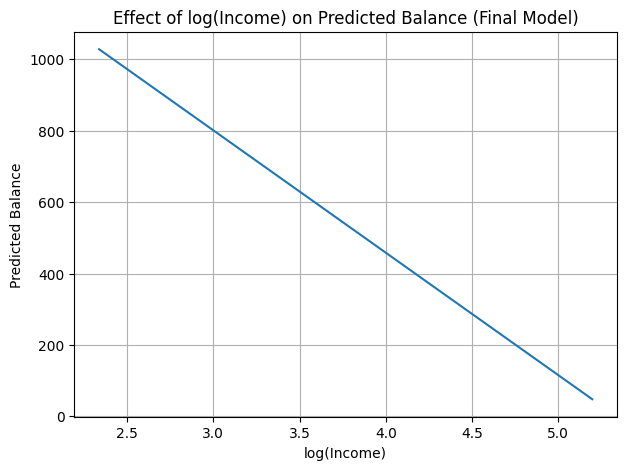

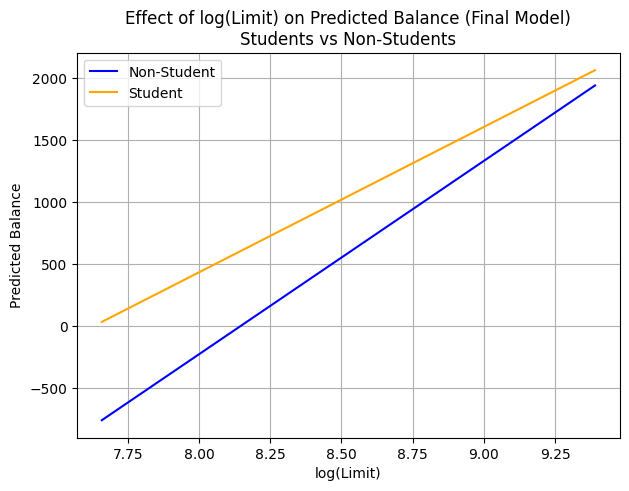

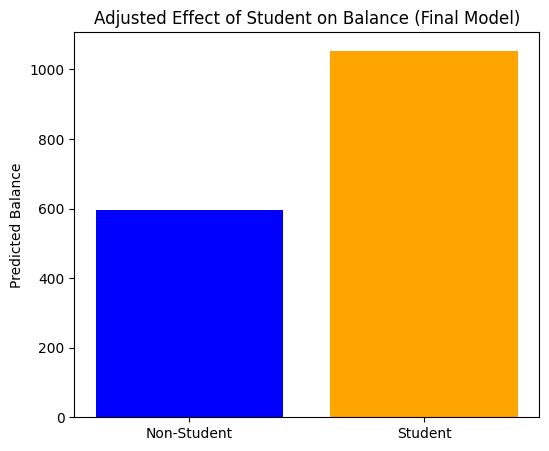

In [46]:
#Effect Plot
# Ranges for predictors
log_income_range_f = np.linspace(df_wo['log_Income'].min(), df_wo['log_Income'].max(), 100)
log_limit_range_f  = np.linspace(df_wo['log_Limit'].min(),  df_wo['log_Limit'].max(),  100)

avg_inc_f = df_wo['log_Income'].mean()
avg_lim_f = df_wo['log_Limit'].mean()


# ---------------------------------------------------
# 1. Effect of log(Income)
# ---------------------------------------------------
pred_df_inc_f = pd.DataFrame({
    'log_Income': log_income_range_f,
    'log_Limit': avg_lim_f,
    'Student': ['No'] * 100
})
pred_df_inc_f['Pred'] = model_wo.predict(pred_df_inc_f)

plt.figure(figsize=(7,5))
plt.plot(log_income_range_f, pred_df_inc_f['Pred'])
plt.title("Effect of log(Income) on Predicted Balance (Final Model)")
plt.xlabel("log(Income)")
plt.ylabel("Predicted Balance")
plt.grid(True)
plt.show()


# ---------------------------------------------------
# 2. Effect of log(Limit) for Students vs Non-Students
# ---------------------------------------------------
pred_no = pd.DataFrame({
    'log_Income': avg_inc_f,
    'log_Limit': log_limit_range_f,
    'Student': ['No'] * 100
})
pred_no['Pred'] = model_wo.predict(pred_no)

pred_yes = pd.DataFrame({
    'log_Income': avg_inc_f,
    'log_Limit': log_limit_range_f,
    'Student': ['Yes'] * 100
})
pred_yes['Pred'] = model_wo.predict(pred_yes)

plt.figure(figsize=(7,5))
plt.plot(log_limit_range_f, pred_no['Pred'], label='Non-Student', color='blue')
plt.plot(log_limit_range_f, pred_yes['Pred'], label='Student', color='orange')
plt.title("Effect of log(Limit) on Predicted Balance (Final Model)\nStudents vs Non-Students")
plt.xlabel("log(Limit)")
plt.ylabel("Predicted Balance")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------
# 3. Adjusted Effect of Student
# ---------------------------------------------------
pred_student_f = pd.DataFrame({
    'log_Income': [avg_inc_f, avg_inc_f],
    'log_Limit':  [avg_lim_f, avg_lim_f],
    'Student':    ['No','Yes']
})
pred_student_f['Pred'] = model_wo.predict(pred_student_f)

plt.figure(figsize=(6,5))
plt.bar(['Non-Student','Student'], pred_student_f['Pred'], color=['blue','orange'])
plt.title("Adjusted Effect of Student on Balance (Final Model)")
plt.ylabel("Predicted Balance")
plt.show()
